In [1]:
import os
import errno

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell.utils.data_utils import make_training_data
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
from deepcell.training import train_model_conv

Using TensorFlow backend.


## Load the Training Data

In [2]:
RESIZE = True
RESHAPE_SIZE = 512

# filepath constants 
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/ecoli/kc'
DATA_FILE = 'ecoli_kc'.format(K.image_data_format())

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 3

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    dimensionality=2,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, DATA_FILE),
    training_direcs=['set1', 'set2'],
    channel_names=['phase'],
    raw_image_direc='processed',
    annotation_direc='annotated',
    reshape_size=RESHAPE_SIZE if RESIZE else None)

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Reshaped feature data from (2, 1002, 1004, 1) to (8, 512, 512, 1)
Reshaped training data from (2, 1002, 1004, 1) to (8, 512, 512, 1)
Data Saved to /data/npz_data/cells/ecoli/kc/ecoli_kc.npz


## Fully Convolutional Training

In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])
    
# Set up other training parameters
n_epoch = 50
batch_size = 1
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (8, 512, 512, 1)
y.shape: (8, 512, 512, 1)


In [5]:
# Instantiate the model
conv_model = bn_feature_net_skip_2D(
    receptive_field=61,
    n_skips=3,
    n_features=4,  # (background edge, interior edge, cell interior, background)
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    multires=False,
    last_only=False)

# Train the model
train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,
    expt='conv',
    transform='deepcell',
    dilation_radius=1,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (7, 512, 512, 1)
y_train shape: (7, 512, 512, 1)
X_test shape: (1, 512, 512, 1)
y_test shape: (1, 512, 512, 1)
Output Shape: (None, 512, 512, 4)
Number of Classes: 4
Epoch 1/50
6/7 [========================>.....] - ETA: 1s - loss: 4.9983 - model_1_loss: 1.2381 - model_2_loss: 1.2367 - model_3_loss: 1.2380 - model_4_loss: 1.2575 - model_1_acc: 0.2891 - model_2_acc: 0.4378 - model_3_acc: 0.2725 - model_4_acc: 0.4260
Epoch 00001: val_loss improved from inf to 6.02601, saving model to /data/models/cells/ecoli/kc/2018-09-05_ecoli_kc_conv.h5
7/7 [==============================] - 13s 2s/step - loss: 4.7853 - model_1_loss: 1.1936 - model_2_loss: 1.1807 - model_3_loss: 1.1888 - model_4_loss: 1.1942 - model_1_acc: 0.2950 - model_2_acc: 0.4480 - model_3_acc: 0.2778 - model_4_acc: 0.4324 - val_loss: 6.0260 - val_model_1_loss: 1.8684 - val_model_2_loss: 1.5011 - val_model_3_loss: 1.3375 - val_model_4_loss: 1.2910 - val_model_1_acc: 0.7840 - val_model_2_acc: 0.8327 - val_model_3_acc

Epoch 11/50
6/7 [========================>.....] - ETA: 0s - loss: 2.2565 - model_1_loss: 0.5458 - model_2_loss: 0.5562 - model_3_loss: 0.5575 - model_4_loss: 0.5687 - model_1_acc: 0.7961 - model_2_acc: 0.7794 - model_3_acc: 0.7927 - model_4_acc: 0.7776
Epoch 00011: val_loss improved from 3.40945 to 3.31000, saving model to /data/models/cells/ecoli/kc/2018-09-05_ecoli_kc_conv.h5
7/7 [==============================] - 4s 641ms/step - loss: 2.3523 - model_1_loss: 0.5705 - model_2_loss: 0.5806 - model_3_loss: 0.5819 - model_4_loss: 0.5912 - model_1_acc: 0.7999 - model_2_acc: 0.7820 - model_3_acc: 0.7986 - model_4_acc: 0.7880 - val_loss: 3.3100 - val_model_1_loss: 0.8202 - val_model_2_loss: 0.8110 - val_model_3_loss: 0.8266 - val_model_4_loss: 0.8240 - val_model_1_acc: 0.8346 - val_model_2_acc: 0.7651 - val_model_3_acc: 0.8860 - val_model_4_acc: 0.8555
Epoch 12/50
6/7 [========================>.....] - ETA: 0s - loss: 2.1682 - model_1_loss: 0.5257 - model_2_loss: 0.5401 - model_3_loss: 0.5

Epoch 21/50
6/7 [========================>.....] - ETA: 0s - loss: 2.0352 - model_1_loss: 0.4696 - model_2_loss: 0.5085 - model_3_loss: 0.5028 - model_4_loss: 0.5259 - model_1_acc: 0.7973 - model_2_acc: 0.7908 - model_3_acc: 0.7957 - model_4_acc: 0.7843
Epoch 00021: val_loss did not improve
7/7 [==============================] - 4s 596ms/step - loss: 1.8412 - model_1_loss: 0.4222 - model_2_loss: 0.4653 - model_3_loss: 0.4521 - model_4_loss: 0.4732 - model_1_acc: 0.8074 - model_2_acc: 0.8009 - model_3_acc: 0.8057 - model_4_acc: 0.7910 - val_loss: 2.5274 - val_model_1_loss: 0.5890 - val_model_2_loss: 0.6005 - val_model_3_loss: 0.6288 - val_model_4_loss: 0.6808 - val_model_1_acc: 0.9260 - val_model_2_acc: 0.9147 - val_model_3_acc: 0.9293 - val_model_4_acc: 0.9300
Epoch 22/50
6/7 [========================>.....] - ETA: 0s - loss: 1.8324 - model_1_loss: 0.4184 - model_2_loss: 0.4679 - model_3_loss: 0.4380 - model_4_loss: 0.4798 - model_1_acc: 0.8052 - model_2_acc: 0.8075 - model_3_acc: 0.80

Epoch 41/50
6/7 [========================>.....] - ETA: 0s - loss: 1.7724 - model_1_loss: 0.4310 - model_2_loss: 0.4451 - model_3_loss: 0.4388 - model_4_loss: 0.4291 - model_1_acc: 0.8189 - model_2_acc: 0.8195 - model_3_acc: 0.8225 - model_4_acc: 0.8169
Epoch 00041: val_loss improved from 1.88019 to 1.85667, saving model to /data/models/cells/ecoli/kc/2018-09-05_ecoli_kc_conv.h5
7/7 [==============================] - 4s 643ms/step - loss: 1.6107 - model_1_loss: 0.3900 - model_2_loss: 0.4039 - model_3_loss: 0.3979 - model_4_loss: 0.3904 - model_1_acc: 0.8133 - model_2_acc: 0.8136 - model_3_acc: 0.8171 - model_4_acc: 0.8100 - val_loss: 1.8567 - val_model_1_loss: 0.4575 - val_model_2_loss: 0.4568 - val_model_3_loss: 0.4690 - val_model_4_loss: 0.4450 - val_model_1_acc: 0.9317 - val_model_2_acc: 0.9257 - val_model_3_acc: 0.9312 - val_model_4_acc: 0.9287
Epoch 42/50
6/7 [========================>.....] - ETA: 0s - loss: 1.5010 - model_1_loss: 0.3693 - model_2_loss: 0.3703 - model_3_loss: 0.3

In [6]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='conv', seed=21)

X_test, y_test = test_dict['X'], test_dict['y']

test_images = conv_model.predict(X_test)[-1]

print('model output shape:', test_images.shape)

model output shape: (1, 512, 512, 4)


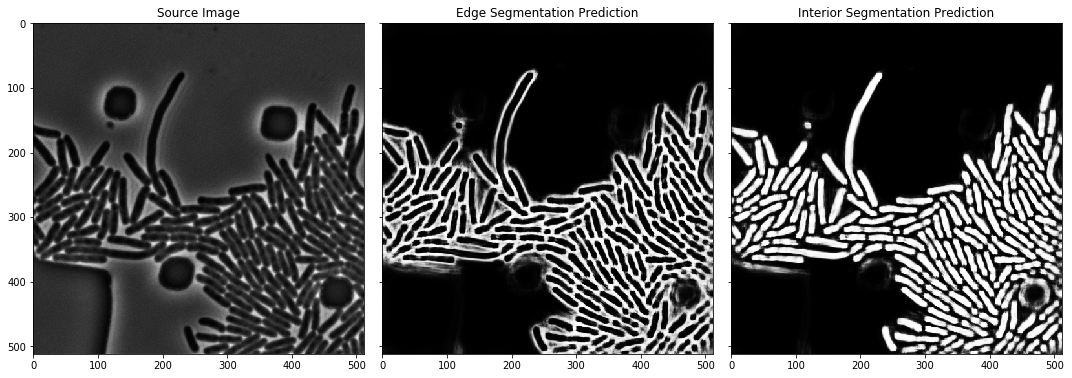

In [7]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(test_images[index, :, :, 0] + test_images[index, :, :, 1], cmap='gray')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(test_images[index, :, :, 2], cmap='gray')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()